In [1]:
# Importing Libraries
import pandas as pd
from pandas.errors import ParserError
import re

import datetime
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import kruskal
from scipy.stats import pearsonr
import scikit_posthocs as sp
import pingouin as pg
from pymer4.models import Lmer

import holidays

# **<span style='color:#4267B2'>|</span> Digital Marketing Strategy Project**

**by Viktor Varga**


## 1. **Research question:**

**<center>How can theme parks based in the USA optimize their interactions on Facebook fan pages to achieve maximum customer engagement, while simultaneously aligning with the goals of their communication strategy?**</center>

### **Sub questions:**

1.	 Which features of the text description influence user engagement?
2.   What is the effect of different types of content of posts on user engagement?
3.   How does the timing and contextual factors surrounding a post influence user engagement?

In [2]:
# Importing datasets and handling bad lines - via ChatGPT
def handle_bad_lines(e):
    print(f"Skipping line {e.line}: {e.message}")
    return None

# Importing datasets with skipping bad lines
try:
    df = pd.read_csv(r"df1.csv", sep=";", encoding="cp1252", engine='python', on_bad_lines=handle_bad_lines)
except ParserError as e:
    print(f"Error reading df1.csv: {e}")

try:
    df_2 = pd.read_csv(r"df2.csv", sep=";", encoding="cp1252", engine='python', on_bad_lines=handle_bad_lines)
except ParserError as e:
    print(f"Error reading df2.csv: {e}")

try:
    df_3 = pd.read_csv(r"df5.csv", sep=";", encoding="cp1252", engine='python', on_bad_lines=handle_bad_lines)
except ParserError as e:
    print(f"Error reading df5.csv: {e}")

try:
    df_4 = pd.read_csv(r"df4.csv", sep=";", encoding="cp1252", engine='python', on_bad_lines=handle_bad_lines)
except ParserError as e:
    print(f"Error reading df4.csv: {e}")

df_locations = pd.read_excel(r"Park_location.xlsx")


In [3]:
# Merging the datasets
df = pd.concat([df,df_2,df_3,df_4], axis=0, ignore_index=True)
# Changing the "profile" column to string
df["Profile"] = df["Profile"].astype(str)

In [4]:
# Removing white space to the "profile" column are matching
df_locations["Profile"] = df_locations["Profile"].astype(str)
df_locations["Profile"] = df_locations["Profile"].str.strip()

In [5]:
# Lowering case in both columns
df["Profile"] = df["Profile"].apply(lambda x: x.lower())
df_locations["Profile"] = df_locations["Profile"].apply(lambda x: x.lower())
# Merging the two datasets to create the main dataset
df_main = pd.merge(df, df_locations, on="Profile",validate='many_to_one')

In [6]:
# Printing main df
df_main.head(2)

,Date,Profile,Message,Number of Reactions,Number of Shares,Number of Comments (primary),Number of Shares.1,Comments per post,Comments on posts by fans,Post interaction,...,Link_x,Unnamed: 14,Location,Followers,Type,Link_y,Likes,Visitors,Rating,Income
0,7/21/22 12:05 AM,cedar point,"When you book a stay at Hotel Breakers, the fu...",282.0,NaN,34.0,23.0,41.0,41.0,0.000222,...,https://www.facebook.com/cedarpoint/photos/a.3...,NaN,"Ohio,US",1500412,Amusement park,https://www.facebook.com/cedarpoint/,1563439,2208210,NaN,62689
1,7/18/22 9:00 PM,cedar point,"It’s Truce Day at Cedar Point, and you’re invi...",264.0,NaN,31.0,53.0,37.0,37.0,0.000227,...,https://www.facebook.com/10625691462/posts/101...,NaN,"Ohio,US",1500412,Amusement park,https://www.facebook.com/cedarpoint/,1563439,2208210,NaN,62689


In [7]:
# Dropping unnecceassary columns
df_main = df_main.drop(columns=['Link_y','Link_x', 'Visitors', 'Rating', 'Number of Shares', 'Unnamed: 14'])
# Renaming columns
df_main.rename(columns={'Number of Reactions': 'Reactions', 'Number of Shares.1': 'Shares', 'Comments per post': 'Comments', 'Comments on posts by fans': 'Comments_by_fans'}, inplace=True)
# Dropping NaNs in the "Profile column"
df_main = df_main.dropna(subset=['Profile'])

## **<span style='color:#4267B2'>|</span> 2. Feature engineering:**

### **<span style='color:#4267B2'>|</span> 2.1 Day and Time based features:**

In [8]:
# Extracting Day of week from "Date" column
df_main["Day"] = pd.to_datetime(df_main["Date"], format='%m/%d/%y %I:%M %p').dt.day_name()

In [9]:
# Extracting Time from "Date" column
df_main["Time"] = pd.to_datetime(df_main["Date"], format='%m/%d/%y %I:%M %p').dt.time
# Grouping into Time categories (0 ; Night, 1 ; Lunch, 2 ; Afternoon, 3 ; Evening)
df_main["TimeCategory"] = df_main["Time"].apply(lambda x: 
    0 if 5 <= x.hour < 12 else    # Morning: 5 am to 12 pm 
    1 if 12 <= x.hour < 17 else   # Afternoon: 12 pm to 5 pm
    2 if 17 <= x.hour < 21 else   # Evening: 5 pm to 9 pm
    3                            # Night: 9 pm to 4 am
)

In [10]:
# Making a text based column of "TimeCategory"
# Defining a mapping function
def map_time_category_to_text(time):
    if time == 0:
        return "Morning"
    elif time == 1:
        return "Noon"
    elif time == 2:
        return "Evening"
    elif time == 3:
        return "Night"
# Creating a new column 'TimeCategoryText' using the mapping function
df_main['TimeCategoryText'] = df_main['TimeCategory'].apply(map_time_category_to_text)

In [11]:
df_main.head(2)

,Date,Profile,Message,Reactions,Number of Comments (primary),Shares,Comments,Comments_by_fans,Post interaction,Engagement,...,Post-ID,Location,Followers,Type,Likes,Income,Day,Time,TimeCategory,TimeCategoryText
0,7/21/22 12:05 AM,cedar point,"When you book a stay at Hotel Breakers, the fu...",282.0,34.0,23.0,41.0,41.0,0.000222,0.000222,...,10625691462_10158936706621463,"Ohio,US",1500412,Amusement park,1563439,62689,Thursday,00:05:00,3,Night
1,7/18/22 9:00 PM,cedar point,"It’s Truce Day at Cedar Point, and you’re invi...",264.0,31.0,53.0,37.0,37.0,0.000227,0.000227,...,10625691462_10158933698001463,"Ohio,US",1500412,Amusement park,1563439,62689,Monday,21:00:00,3,Night


In [12]:
# Reformating the date column
df_main["Date"] = pd.to_datetime(df_main["Date"], format='%m/%d/%y %I:%M %p')

In [13]:
# Defining whether day of posting was a holiday or not
US_holidays = holidays.US()
df_main["Holiday"] = df_main["Date"].apply(lambda date: 1 if date in US_holidays or date.weekday() == 6 else 0)

In [14]:
# Defining during what seasons have post been posted
def get_month_season(date):
    month_name = date.strftime('%B') # Get full month name in string form
    
    if month_name in ['December', 'January', 'February']:
        return 'Winter'
    elif month_name in ['March', 'April', 'May']:
        return 'Spring'
    elif month_name in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'
    
# Applying the function to the 'Date' column and create new 'MonthName' and 'Season' columns
df_main['MonthName'] = df_main['Date'].apply(lambda x: x.strftime('%B'))
df_main['Season'] = df_main['Date'].apply(lambda x: get_month_season(x))

In [15]:
df_main.tail(8)

,Date,Profile,Message,Reactions,Number of Comments (primary),Shares,Comments,Comments_by_fans,Post interaction,Engagement,...,Type,Likes,Income,Day,Time,TimeCategory,TimeCategoryText,Holiday,MonthName,Season
10488,2021-08-27 15:00:00,playland park,We made it to Friday! Join us tonight for fire...,25.0,2.0,1.0,2.0,2.0,NaN,NaN,...,Theme City,NaN,72920,Friday,15:00:00,1,Noon,0,August,Summer
10489,2021-08-26 18:00:00,playland park,"Two nights of fireworks begin tonight, Thursda...",39.0,3.0,1.0,3.0,3.0,NaN,NaN,...,Theme City,NaN,72920,Thursday,18:00:00,2,Evening,0,August,Summer
10490,2021-08-25 18:00:00,playland park,"Reminder: Special fireworks display tomorrow, ...",10.0,0.0,0.0,0.0,0.0,NaN,NaN,...,Theme City,NaN,72920,Wednesday,18:00:00,2,Evening,0,August,Summer
10491,2021-08-25 15:00:00,playland park,Put Playland Park on your summer to-do list an...,29.0,0.0,2.0,0.0,0.0,NaN,NaN,...,Theme City,NaN,72920,Wednesday,15:00:00,1,Noon,0,August,Summer
10492,2021-08-24 18:00:00,playland park,"So nice, we're doing it twice! Join us for a s...",14.0,0.0,2.0,0.0,0.0,NaN,NaN,...,Theme City,NaN,72920,Tuesday,18:00:00,2,Evening,0,August,Summer
10493,2021-08-21 17:45:00,playland park,Due to the latest updates surrounding the weat...,16.0,2.0,2.0,3.0,3.0,NaN,NaN,...,Theme City,NaN,72920,Saturday,17:45:00,2,Evening,0,August,Summer
10494,2021-08-21 15:00:00,playland park,"Everything is better with music, right? The DJ...",17.0,0.0,0.0,0.0,0.0,NaN,NaN,...,Theme City,NaN,72920,Saturday,15:00:00,1,Noon,0,August,Summer
10495,2021-08-20 15:00:00,playland park,Only a few more Friday night fireworks left th...,25.0,2.0,0.0,4.0,4.0,NaN,NaN,...,Theme City,NaN,72920,Friday,15:00:00,1,Noon,0,August,Summer


### <span style='color:#4267B2'>|</span> **2.2 Text based features**

In [16]:
# Counting number of #s in post description
df_main["Hashtags"] = df_main["Message"].apply(lambda x: x.count("#"))
# Measuring length of text in post description
df_main["Length"] = (df_main["Message"].apply(lambda x: x.count(" ")) + 2)


### **Gunning Fog index**


In [17]:
# Cleaning text before the formula is applied
# Storing the text in a seperate variable
raw_text = df_main["Message"]
# Defining a function to clean the text
def clean_text(text):
    # Removing emojis
    text = re.sub(r"[\U00010000-\U0010ffff]", "", text)
    
    # Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+|bit\.ly\S+", "", text, flags=re.MULTILINE)
    
    # Removing hashtags
    text = re.sub(r"#\S+", "", text)
    
    return text

# Applying the function to the "Message" column
df_main["Cleaned_Message"] = raw_text.apply(clean_text)

In [18]:
# Tokenizing the text into sentences using nltk module
def segment_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

df_main['Sentences'] = df_main['Cleaned_Message'].apply(segment_sentences)

In [19]:
# Observing how cleaned the text is
df_main[['Cleaned_Message','Sentences']].head(6)

,Cleaned_Message,Sentences
0,"When you book a stay at Hotel Breakers, the fu...","[When you book a stay at Hotel Breakers, the f..."
1,"It’s Truce Day at Cedar Point, and you’re invi...","[It’s Truce Day at Cedar Point, and you’re inv..."
2,Curtis the cow is awful hungry at The Barnyard...,[Curtis the cow is awful hungry at The Barnyar...
3,"Which team do you got on Gemini?Comment ""??"" f...","[Which team do you got on Gemini?Comment ""??"",..."
4,?Announcing a new member of our social media t...,[?Announcing a new member of our social media ...
5,?The category is...ORNAMENTS?It's NEVER too ea...,[?The category is...ORNAMENTS?It's NEVER too e...


In [20]:
# Further cleaning the sentences column
def clean_sentences(sentences):
    cleaned_sentences = []

    for sentence in sentences:
        # Remove "?" at the beginning of sentences
        sentence = re.sub(r'^\?', '', sentence)
        
        # Remove "?" within sentences
        sentence = sentence.replace('?', '')
        
        # Remove extra whitespaces
        sentence = ' '.join(sentence.split())

        cleaned_sentences.append(sentence)

    return cleaned_sentences

df_main['Cleaned_Sentences'] = df_main['Sentences'].apply(clean_sentences)

In [21]:
# Defining the function that utilizes the Gunning Fog formula
def calculate_gunning_fog(sentences):
    # Counting the number of words and complex words
    num_words = 0
    num_complex_words = 0

    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        num_words += len(words)
        for word in words:
            if len(word) >= 3 and len(re.findall('[aeiouyAEIOUY]+', word)) >= 3:
                num_complex_words += 1

    # Calculating the Gunning-Fog score
    if num_words == 0:
        return 0
    else:
        return 0.4 * ((num_words / len(sentences)) + (100 * (num_complex_words / num_words)))
    
# Applying the function on the dataset
df_main['Gunning_Fog_Score'] = df_main['Cleaned_Sentences'].apply(calculate_gunning_fog)

In [22]:
# Final observation
df_main[['Gunning_Fog_Score', 'Cleaned_Sentences']].head(10)

,Gunning_Fog_Score,Cleaned_Sentences
0,8.333333,"[When you book a stay at Hotel Breakers, the f..."
1,8.978049,"[It’s Truce Day at Cedar Point, and you’re inv..."
2,2.600000,[Curtis the cow is awful hungry at The Barnyar...
3,4.228571,"[Which team do you got on GeminiComment """", fo..."
4,16.266667,[Announcing a new member of our social media t...
5,13.295652,[The category is...ORNAMENTSIt's NEVER too ear...
6,1.600000,"[, It's a good week to have a good week at Ced..."
7,7.182439,"[Sawmill Creek HIRING EVENT, Tuesday, July 12,..."
8,6.051541,"[, ""Hey, hey it's gonna be great!, Come & join..."
9,10.333333,"[What was the world's FIRST giga coaster, Mill..."


### **Topic Modelling**

In [23]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10496 entries, 0 to 10495
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          10496 non-null  datetime64[ns]
 1   Profile                       10496 non-null  object        
 2   Message                       10496 non-null  object        
 3   Reactions                     10496 non-null  float64       
 4   Number of Comments (primary)  10496 non-null  float64       
 5   Shares                        10496 non-null  float64       
 6   Comments                      10496 non-null  float64       
 7   Comments_by_fans              10496 non-null  float64       
 8   Post interaction              8998 non-null   float64       
 9   Engagement                    8998 non-null   float64       
 10  Profile-ID                    10496 non-null  float64       
 11  Post-ID                     

In [24]:
# Initiaite the TfidfVectorizer with desired settings
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

# Fitting and transforming the text data
tfidf = vectorizer.fit_transform(df_main['Cleaned_Sentences'].apply(lambda x: ' '.join(x)))
# Set the NMF model with desired number of topics (k)
k = 8
nmf_model = NMF(n_components=k, random_state=42)

# Fitting the model to the tfidf matrix
nmf_model.fit(tfidf)

# extract the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# print the top 10 words for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    print("Topic %d:" % (topic_idx))
    print(", ".join([feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]))

Topic 0:
weekend, food, festival, ready, seas, seven, concerts, tonight, admission, come, join, sunday, included, available, seating
Topic 1:
pass, season, 2022, unlimited, free, 2023, visits, buy, gold, year, price, purchase, rest, parking, member
Topic 2:
thrill, fun, family, finest, arizona, 7575, 997, 602, park, castles, coasters, arizonas, golf, arcade, mini
Topic 3:
happy, hollow, day, birthday, zoo, year, animals, animal, thanksgiving, team, new, happyhollow, wishing, celebrate, mother
Topic 4:
tickets, sale, save, passes, ends, don, offer, cards, miss, hurry, purchase, fun, friday, buy, link
Topic 5:
halloween, boo, trick, fest, gilroy, enjoy, fall, gardens, night, october, fun, fright, spooktacular, event, experience
Topic 6:
holiday, christmas, lights, new, santa, park, magic, celebration, town, event, merry, nov, season, year, holidays
Topic 7:
day, open, today, park, summer, visit, water, 10, come, ride, pm, sunday, hours, rides, tomorrow


c:\Users\Trabala\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### **Based on these keywords, the topics can get categories into the specific content types as follows:**

Topic 0 : Information post

Topic 1: Renumeration post

Topic 2: Entertainment post

Topic 3: Entertainment post

Topic 4: Renumeration post

Topic 5: Entertainment post

Topic 6: Entertainment post

Topic 7: Information post

*Note: based on these keywords we were not able to clearly identify any "Social" posts, so we will be ommiting this category in this research*

In [25]:
# Transforming Clean_Sentences into TF-IDF matrix
tfidf_matrix = vectorizer.transform(df_main['Cleaned_Sentences'].apply(lambda x: ' '.join(x)))

# Using NMF model to transform TF-IDF matrix into topic space
topic_weights = nmf_model.transform(tfidf_matrix)

# Assigning the most dominant topic to each message
df_main['Dominant_Topic'] = np.argmax(topic_weights, axis=1)

# Displaying the result, including the Gunning Fog Score for context
result_df = df_main[['Cleaned_Sentences', 'Gunning_Fog_Score', 'Dominant_Topic']]
result_df

,Cleaned_Sentences,Gunning_Fog_Score,Dominant_Topic
0,"[When you book a stay at Hotel Breakers, the f...",8.333333,1
1,"[It’s Truce Day at Cedar Point, and you’re inv...",8.978049,7
2,[Curtis the cow is awful hungry at The Barnyar...,2.600000,7
3,"[Which team do you got on GeminiComment """", fo...",4.228571,3
4,[Announcing a new member of our social media t...,16.266667,6
...,...,...,...
10491,[Put Playland Park on your summer to-do list a...,6.600000,7
10492,"[So nice, we're doing it twice!, Join us for a...",10.643243,5
10493,[Due to the latest updates surrounding the wea...,11.314286,7
10494,"[Everything is better with music, right, The D...",6.713978,7


In [26]:
# Defining a mapping dictionary based on the provided legend
topic_mapping = {
    0: 'Information post',
    1: 'Renumeration post',
    2: 'Entertainment post',
    3: 'Entertainment post',
    4: 'Renumeration post',
    5: 'Entertainment post',
    6: 'Entertainment post',
    7: 'Information post'
}

# Create a new column 'Topic_Label' by mapping the 'Dominant_Topic' column using the mapping dictionary
df_main['Topic_Label'] = df_main['Dominant_Topic'].map(topic_mapping)

In [27]:
df_main['Topic_Label']

0         Renumeration post
1          Information post
2          Information post
3        Entertainment post
4        Entertainment post
                ...        
10491      Information post
10492    Entertainment post
10493      Information post
10494      Information post
10495     Renumeration post
Name: Topic_Label, Length: 10496, dtype: object

### **2.3 Number based features** 

In [28]:
# Getting the Median income of states categories
df_main["Median_income"] = df_main["Income"].apply(lambda x: "0" if x < 60000 else "1" if 60000 < x < 70000 else "2" if 70000 < x < 80000 else "3")      

## **<span style='color:#4267B2'>|</span> 3. EDA**

### Number of unique FB posts per type of park:

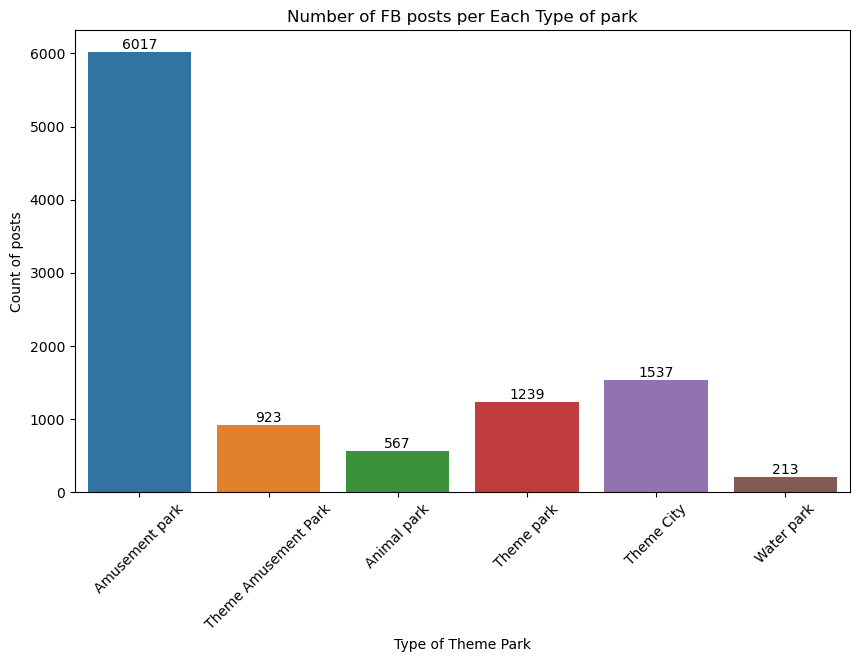

In [29]:
# Creating a countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_main['Type'])

# Adding count labels above each bar
ax.bar_label(ax.containers[0])

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

# Add labels
plt.title('Number of FB posts per Each Type of park')
plt.xlabel('Type of Theme Park')
plt.ylabel('Count of posts')

# Show the plot
plt.show()

### Time of day of post by Park Type:

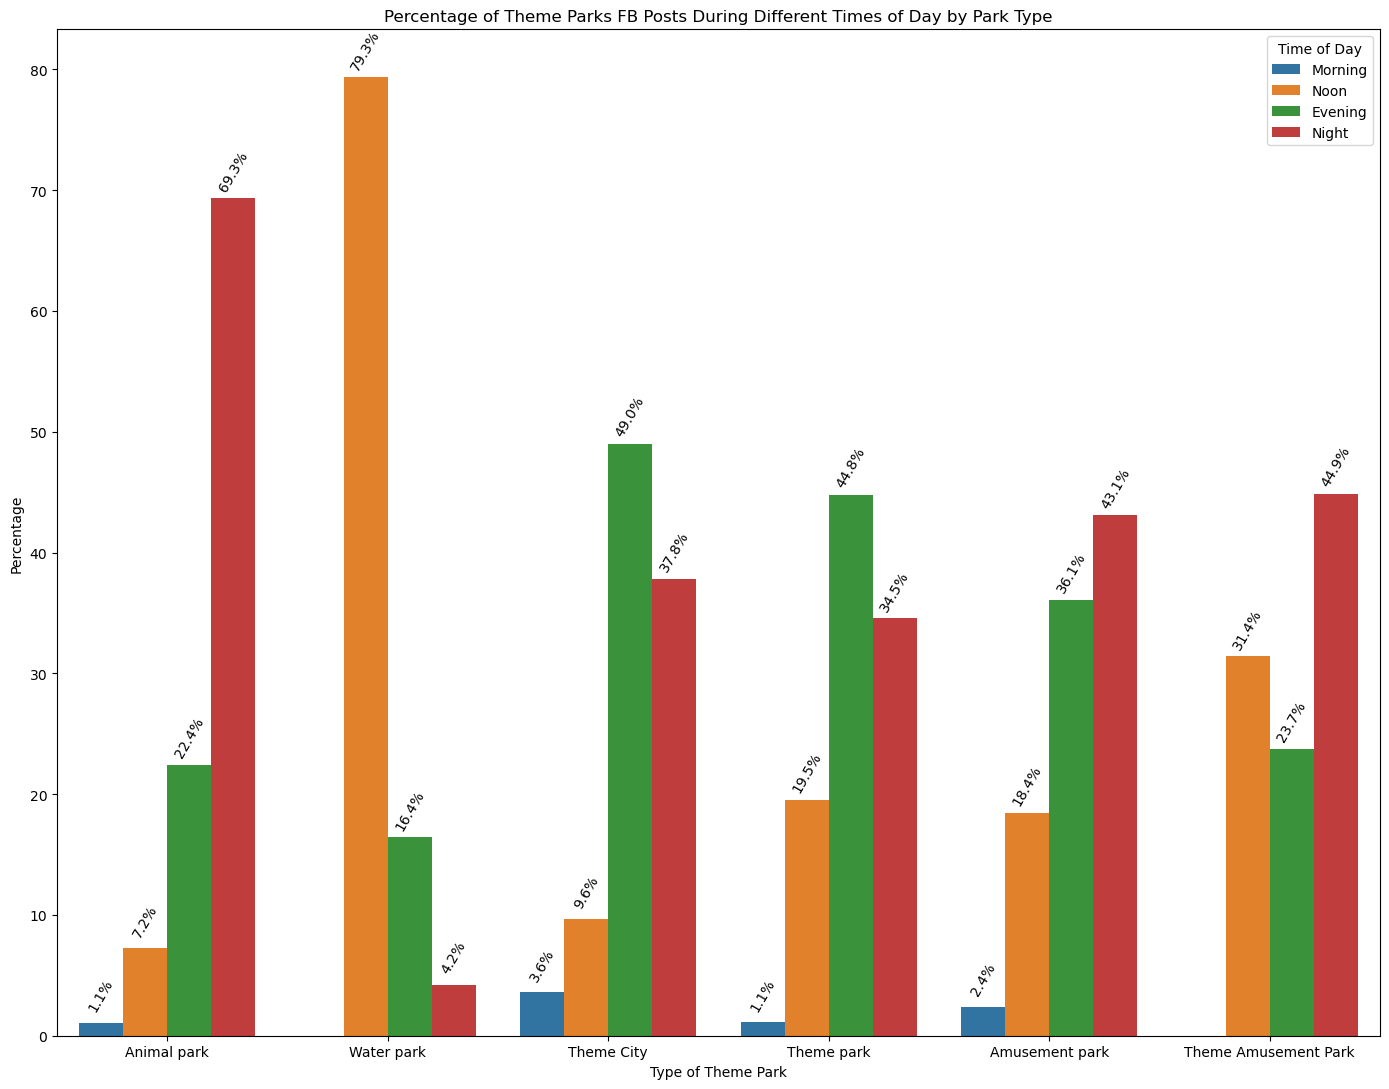

In [30]:
# Calculate counts and percentages
counts = df_main.groupby(['Type', 'TimeCategoryText']).size().reset_index(name='count')
counts['percentage'] = counts['count'] / counts.groupby('Type')['count'].transform('sum') * 100

# Setting order of 'TimeCategoryText'
time_order = ['Morning', 'Noon', 'Evening', 'Night']

# Plot the bar chart
plt.figure(figsize=(14, 11))
sns.barplot(x='Type', y='percentage', hue='TimeCategoryText', data=counts,
            order=counts.groupby('Type')['percentage'].median().sort_values().index,
            hue_order=time_order)  # Set the order of 'TimeCategoryText'

# Adding percentage labels # Chat GPT
ax = plt.gca()
for p in ax.patches:
    label = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='center', xytext=(0, 20), textcoords='offset points', rotation=60)

# Setting plot label properties
plt.title('Percentage of Theme Parks FB Posts During Different Times of Day by Park Type')
plt.xlabel('Type of Theme Park')
plt.ylabel('Percentage')
plt.legend(title='Time of Day')

# Adjusting the layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

### Seasonality of posts by Park type:

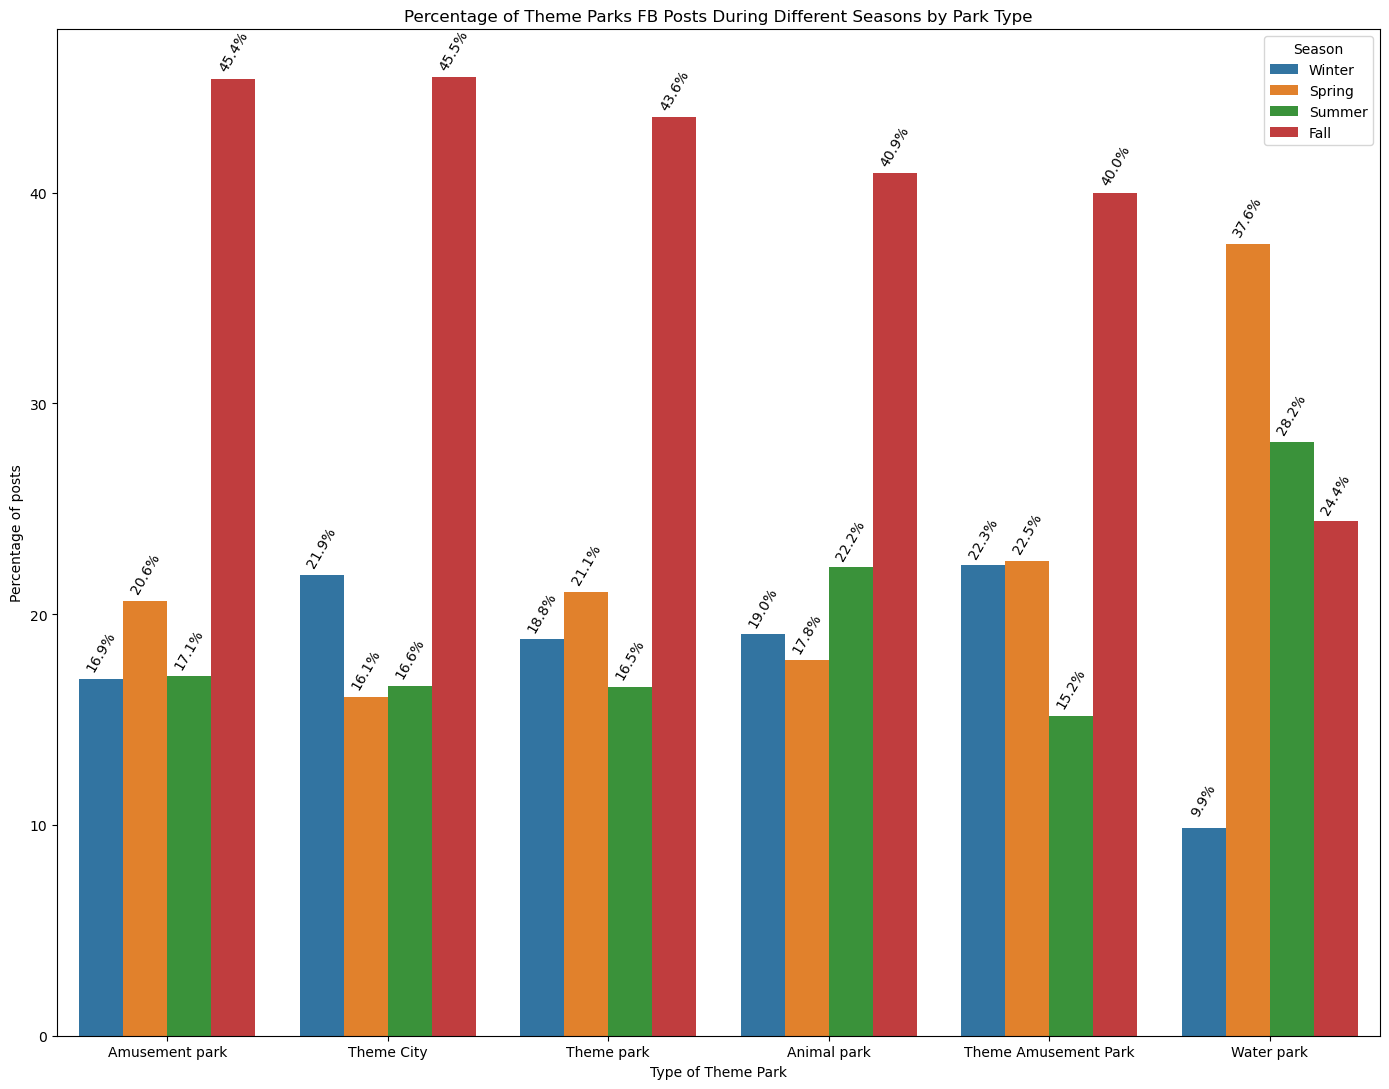

In [31]:
# Calculating counts and percentages
counts = df_main.groupby(['Type', 'Season']).size().reset_index(name='count')
counts['percentage'] = counts['count'] / counts.groupby('Type')['count'].transform('sum') * 100

# Order of 'Season'
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Plotting the bar chart
plt.figure(figsize=(14, 11))
sns.barplot(x='Type', y='percentage', hue='Season', data=counts,
            order=counts.groupby('Type')['percentage'].median().sort_values().index,
            hue_order=season_order)  # Set the order of 'Season'

# Adding percentage labels 
ax = plt.gca()
for p in ax.patches:
    label = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='center', xytext=(0, 20), textcoords='offset points', rotation=60)

# Setting plot properties
plt.title('Percentage of Theme Parks FB Posts During Different Seasons by Park Type')
plt.xlabel('Type of Theme Park')
plt.ylabel('Percentage of posts')
plt.legend(title='Season')

# Adjusting the layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

### Average Number of hashtags in posts per theme park type

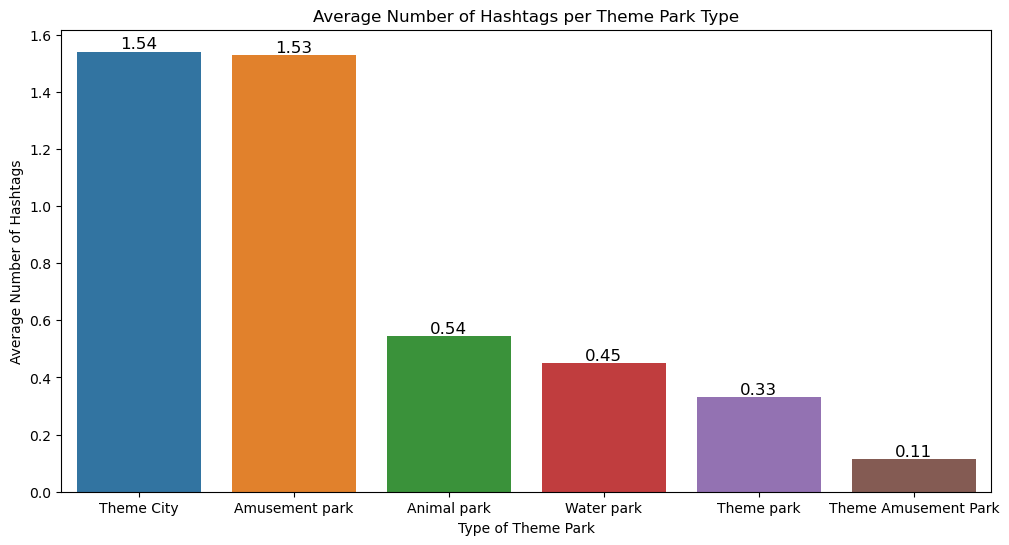

In [32]:
# Plot: Average Number of Hashtags in Posts for each type of theme park
avg_hashtags_df = df_main.groupby('Type')['Hashtags'].mean().reset_index().sort_values(by="Hashtags", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Type', y='Hashtags', data=avg_hashtags_df)
for i, v in enumerate(avg_hashtags_df['Hashtags']):
    plt.annotate("{:.2f}".format(v), xy=(i, v), ha='center', va='bottom', fontsize=12)

# Set plot properties
plt.title('Average Number of Hashtags per Theme Park Type')
plt.xlabel('Type of Theme Park')
plt.ylabel('Average Number of Hashtags')
plt.xticks(rotation=0)
plt.show()

In [33]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10496 entries, 0 to 10495
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          10496 non-null  datetime64[ns]
 1   Profile                       10496 non-null  object        
 2   Message                       10496 non-null  object        
 3   Reactions                     10496 non-null  float64       
 4   Number of Comments (primary)  10496 non-null  float64       
 5   Shares                        10496 non-null  float64       
 6   Comments                      10496 non-null  float64       
 7   Comments_by_fans              10496 non-null  float64       
 8   Post interaction              8998 non-null   float64       
 9   Engagement                    8998 non-null   float64       
 10  Profile-ID                    10496 non-null  float64       
 11  Post-ID                     

### Posted on Weekends/Weekdays:

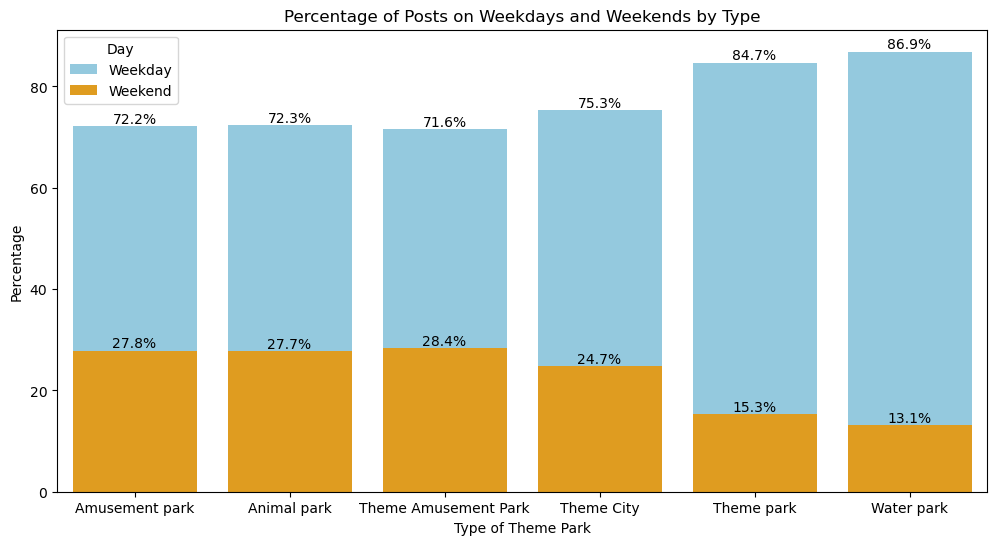

In [34]:
# Converting the "Day" column to a categorical type with the correct order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_main['Day'] = pd.Categorical(df_main['Day'], categories=weekday_order, ordered=True)

# Create a new column for weekdays or weekends
df_main['Posted_Weekday'] = df_main['Day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

# Calculate the percentage of posts for weekdays and weekends per type # Chat GPT
percentage_df = df_main.groupby(['Type', 'Posted_Weekday']).size().unstack(fill_value=0)
percentage_df['Total'] = percentage_df.sum(axis=1)
percentage_df['Percentage_Weekday'] = (percentage_df[True] / percentage_df['Total']) * 100
percentage_df['Percentage_Weekend'] = (percentage_df[False] / percentage_df['Total']) * 100

# Plot the percentages for each type
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Type', y='Percentage_Weekday', data=percentage_df.reset_index(), color='skyblue', label='Weekday')
sns.barplot(x='Type', y='Percentage_Weekend', data=percentage_df.reset_index(), color='orange', label='Weekend')

# Add labels above the bars # Chat GPT
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add labels
plt.title('Percentage of Posts on Weekdays and Weekends by Type')
plt.xlabel('Type of Theme Park')
plt.ylabel('Percentage')
plt.legend(title='Day')

# Show the plot
plt.show()

### Posted through Holidays:

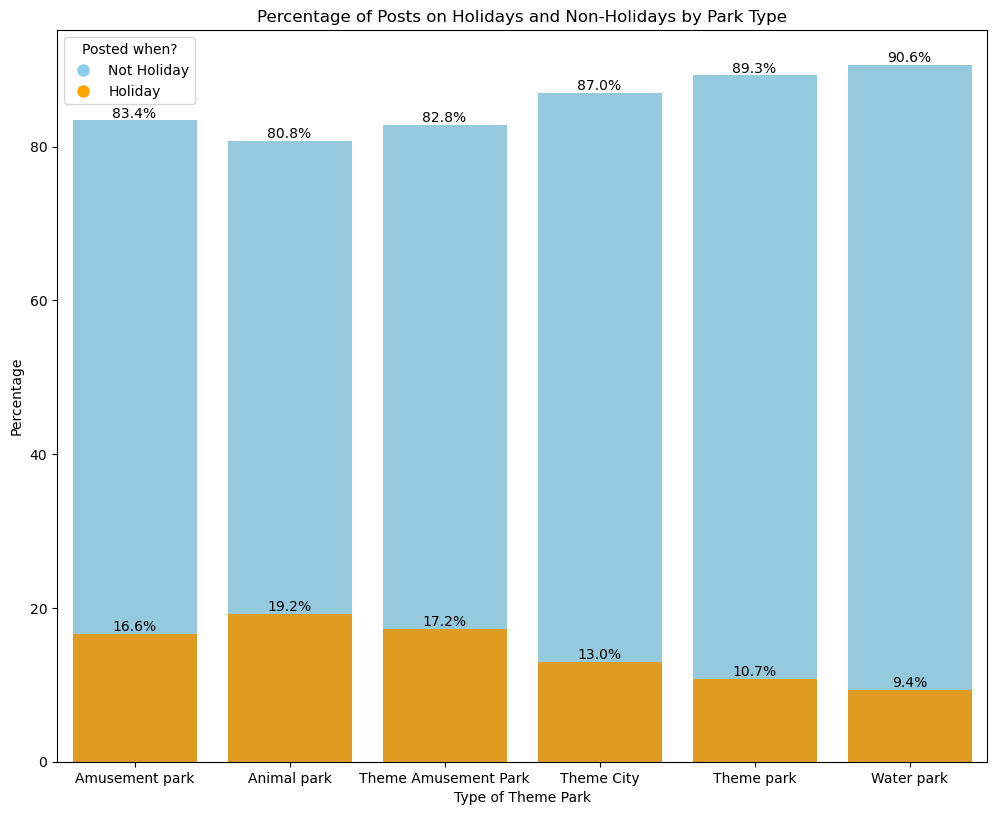

In [35]:
# Calculate the percentage of posts for holidays and non-holidays per type
percentage_holiday_df = df_main.groupby(['Type', 'Holiday']).size().unstack(fill_value=0)
percentage_holiday_df['Total'] = percentage_holiday_df.sum(axis=1)
percentage_holiday_df['Percentage_Not_Holiday'] = (percentage_holiday_df[0] / percentage_holiday_df['Total']) * 100
percentage_holiday_df['Percentage_Holiday'] = (percentage_holiday_df[1] / percentage_holiday_df['Total']) * 100

# Plot the percentages for each type
plt.figure(figsize=(12, 9.5))
ax = sns.barplot(x='Type', y='Percentage_Not_Holiday', data=percentage_holiday_df.reset_index(), color='skyblue', label='Not Holiday')
sns.barplot(x='Type', y='Percentage_Holiday', data=percentage_holiday_df.reset_index(), color='orange', label='Holiday')

# Add labels above the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Addiing labels
plt.title('Percentage of Posts on Holidays and Non-Holidays by Park Type')
plt.xlabel('Type of Theme Park')
plt.ylabel('Percentage')
plt.legend(title='Holiday', labels=['Not Holiday', 'Holiday'])

# Create a custom legend outside the plot # Chat GPT
colors = {'Not Holiday': 'skyblue', 'Holiday': 'orange'}
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors[label], markersize=10) for label in colors]
plt.legend(handles=legend_labels, title='Posted when?', labels=['Not Holiday', 'Holiday'], loc='upper left')

# Show the plot
plt.show()

### Descriptive statistics

In [36]:
df_main.columns

Index(['Date', 'Profile', 'Message', 'Reactions',
       'Number of Comments (primary)', 'Shares', 'Comments',
       'Comments_by_fans', 'Post interaction', 'Engagement', 'Profile-ID',
       'Post-ID', 'Location', 'Followers', 'Type', 'Likes', 'Income', 'Day',
       'Time', 'TimeCategory', 'TimeCategoryText', 'Holiday', 'MonthName',
       'Season', 'Hashtags', 'Length', 'Cleaned_Message', 'Sentences',
       'Cleaned_Sentences', 'Gunning_Fog_Score', 'Dominant_Topic',
       'Topic_Label', 'Median_income', 'Posted_Weekday'],
      dtype='object')

In [37]:
pd.set_option('display.max_colwidth', None)
df_main[['Message','Cleaned_Sentences','Sentences','Cleaned_Message']].head(3)


,Message,Cleaned_Sentences,Sentences,Cleaned_Message
0,"When you book a stay at Hotel Breakers, the fun begins! Did you know you get access to discounted tickets to both Cedar Point and Cedar Point Shores Waterpark, free parking, and unlimited beach access! ?","[When you book a stay at Hotel Breakers, the fun begins!, Did you know you get access to discounted tickets to both Cedar Point and Cedar Point Shores Waterpark, free parking, and unlimited beach access!, ]","[When you book a stay at Hotel Breakers, the fun begins!, Did you know you get access to discounted tickets to both Cedar Point and Cedar Point Shores Waterpark, free parking, and unlimited beach access!, ?]","When you book a stay at Hotel Breakers, the fun begins! Did you know you get access to discounted tickets to both Cedar Point and Cedar Point Shores Waterpark, free parking, and unlimited beach access! ?"
1,"It’s Truce Day at Cedar Point, and you’re invited! Journey to Forbidden Frontier on Adventure Island, the possibilities are endless!? Open daily, except Wednesday's from 12pm-7pm now through August 14th!? https://bit.ly/3IMfdzD","[It’s Truce Day at Cedar Point, and you’re invited!, Journey to Forbidden Frontier on Adventure Island, the possibilities are endless!, Open daily, except Wednesday's from 12pm-7pm now through August 14th!, ]","[It’s Truce Day at Cedar Point, and you’re invited!, Journey to Forbidden Frontier on Adventure Island, the possibilities are endless!?, Open daily, except Wednesday's from 12pm-7pm now through August 14th!, ?]","It’s Truce Day at Cedar Point, and you’re invited! Journey to Forbidden Frontier on Adventure Island, the possibilities are endless!? Open daily, except Wednesday's from 12pm-7pm now through August 14th!?"
2,Curtis the cow is awful hungry at The Barnyard! Pay him a visit the time you're at Cedar Point! ??Open 12pm daily!,"[Curtis the cow is awful hungry at The Barnyard!, Pay him a visit the time you're at Cedar Point!, , Open 12pm daily!]","[Curtis the cow is awful hungry at The Barnyard!, Pay him a visit the time you're at Cedar Point!, ?, ?Open 12pm daily!]",Curtis the cow is awful hungry at The Barnyard! Pay him a visit the time you're at Cedar Point! ??Open 12pm daily!


In [38]:
# Calculate the length of each message
df_main['Message_Length'] = df_main['Message'].apply(lambda x: len(x))

# Group the DataFrame by 'Type' and calculate the mean and median length of messages for each type
length_stats = df_main.groupby('Type')['Message_Length'].agg(['mean', 'median'])

# Print the results
print("Average and Median Length of Message by Park Type:")
print(length_stats)

Average and Median Length of Message by Park Type:
                            mean  median
Type                                    
Amusement park        240.662789   214.0
Animal park           213.804233   201.0
Theme Amusement Park  211.840737   191.0
Theme City            228.332466   205.0
Theme park            155.573043   143.0
Water park             96.262911    92.0


In [39]:
# Calculate the length of each message
df_main['Cln_Message_Length'] = df_main['Cleaned_Message'].apply(lambda x: len(x))

# Group the DataFrame by 'Type' and calculate the mean and median length of messages for each type
length_stats = df_main.groupby('Type')['Cln_Message_Length'].agg(['mean', 'median'])

# Print the results
print("Average and Median Length of Message by Park Type:")
print(length_stats)

Average and Median Length of Message by Park Type:
                            mean  median
Type                                    
Amusement park        211.462523   184.0
Animal park           191.285714   178.0
Theme Amusement Park  199.228602   174.0
Theme City            198.246584   176.0
Theme park            142.498789   129.0
Water park             88.788732    82.0


In [40]:
# Calculate the length of each cleaned message (No links and #s)
df_main['Cln_Message_Length'] = df_main['Message'].apply(lambda x: len(x))

# Group the DataFrame by 'Type' and calculate the mean and median length of messages for each type
length_stats = df_main.groupby('Type')['Cln_Message_Length'].agg(['mean', 'median'])

# Print the results
print("Average and Median Length of Message by Park Type:")
print(length_stats)

Average and Median Length of Message by Park Type:
                            mean  median
Type                                    
Amusement park        240.662789   214.0
Animal park           213.804233   201.0
Theme Amusement Park  211.840737   191.0
Theme City            228.332466   205.0
Theme park            155.573043   143.0
Water park             96.262911    92.0


### Correlation Matrix Analysis

In [41]:
df_main.columns

Index(['Date', 'Profile', 'Message', 'Reactions',
       'Number of Comments (primary)', 'Shares', 'Comments',
       'Comments_by_fans', 'Post interaction', 'Engagement', 'Profile-ID',
       'Post-ID', 'Location', 'Followers', 'Type', 'Likes', 'Income', 'Day',
       'Time', 'TimeCategory', 'TimeCategoryText', 'Holiday', 'MonthName',
       'Season', 'Hashtags', 'Length', 'Cleaned_Message', 'Sentences',
       'Cleaned_Sentences', 'Gunning_Fog_Score', 'Dominant_Topic',
       'Topic_Label', 'Median_income', 'Posted_Weekday', 'Message_Length',
       'Cln_Message_Length'],
      dtype='object')

In [42]:
# Creating a new DataFrame for Correlation Matrix with selected columns
selected_columns = ['Type', 'Engagement', 'Followers', 'Length', 'Hashtags', 'Season', 'Gunning_Fog_Score','TimeCategory', 'Posted_Weekday', 'Holiday', 'Median_income', 'Dominant_Topic']
corr_df = df_main[selected_columns].copy()

In [43]:
# Defining a mapping from text to integer for seasons
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}

corr_df['Season'] = corr_df['Season'].map(season_mapping)

In [44]:
# Defining a mapping from text to integer for type of park
type_mapping = {"Amusement park": 0, "Theme City": 1, "Theme park":2, "Theme Amusement Park":3, "Animal park":4, "Water park":5}

corr_df['Type'] = corr_df['Type'].map(type_mapping)

In [45]:
corr_df

,Type,Engagement,Followers,Length,Hashtags,Season,Gunning_Fog_Score,TimeCategory,Posted_Weekday,Holiday,Median_income,Dominant_Topic
0,0,0.000222,1500412,37,0,3,8.333333,3,True,0,1,1
1,0,0.000227,1500412,32,0,3,8.978049,3,True,0,1,7
2,0,0.000289,1500412,23,0,3,2.600000,2,False,1,1,7
3,0,0.000267,1500412,24,0,3,4.228571,1,False,0,1,3
4,0,0.000313,1500412,43,0,3,16.266667,3,True,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
10491,1,NaN,45000,27,2,3,6.600000,1,True,0,2,7
10492,1,NaN,45000,32,0,3,10.643243,2,True,0,2,5
10493,1,NaN,45000,24,0,3,11.314286,2,False,0,2,7
10494,1,NaN,45000,31,2,3,6.713978,1,False,0,2,7


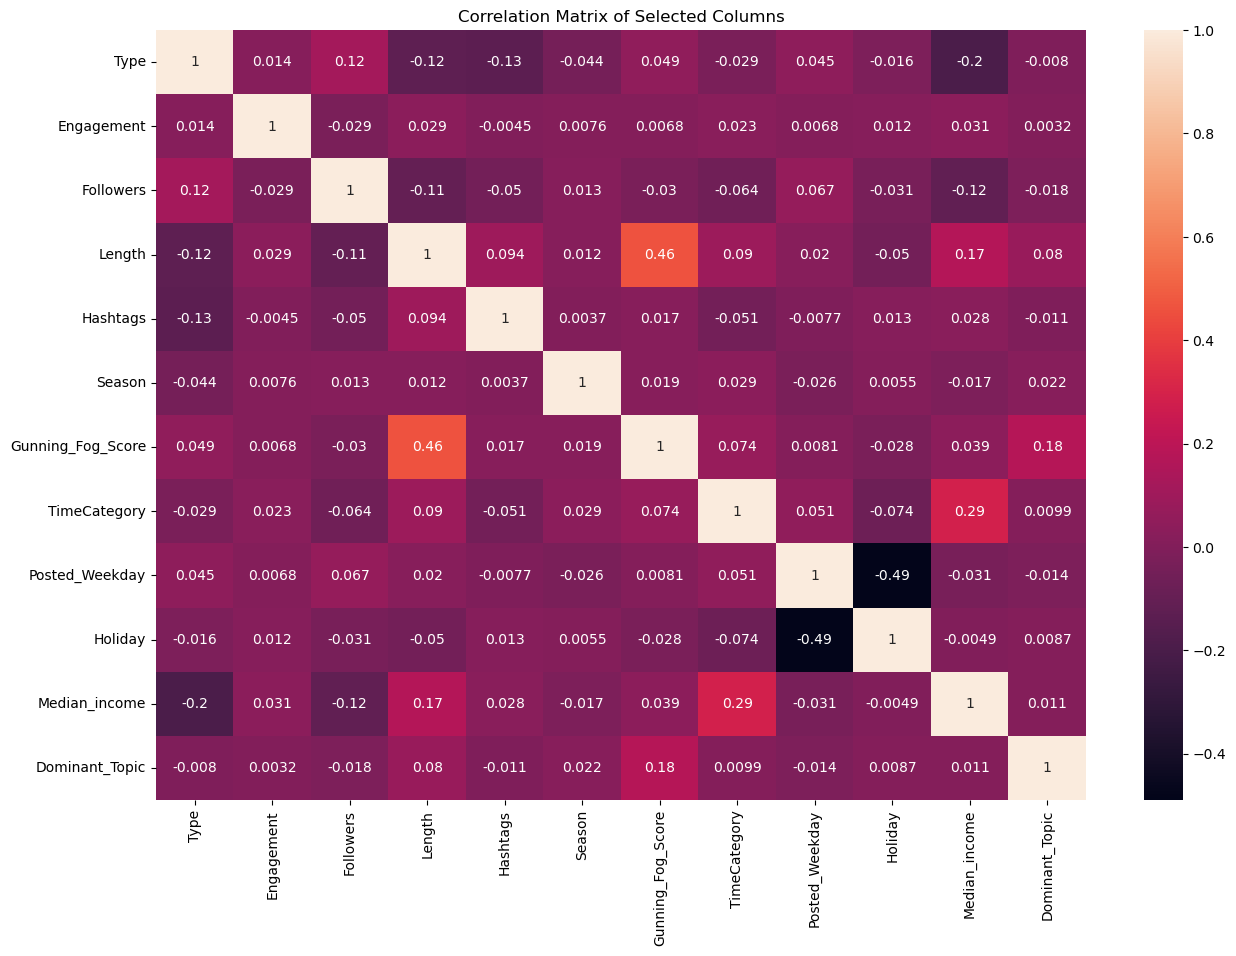

In [46]:
# Calculate the correlation matrix
corr_matrix = corr_df.corr()

# Plot a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.title("Correlation Matrix of Selected Columns")
plt.show()

**Takeaways:** Nothing out of the ordinary, the only high multicolinarity recorded is between variables that are related i.e. Gunning_Fog_Score and Lenght of post, as well as Weeked posts and Holidays.

## **<span style='color:#4267B2'>|</span> 4. Analysis**

### In this section the analysis of the features is conducted to answer the numerous hypotheses put up in the paper.

#### First we will check for Correlation between the main variable **"Engagement"** and the numerous variables we created in the **Feature engineering section**.
 
#### In order to accomplish this, we will employ common correlation tests such as the **Kruskal-Wallis H** test or the **Spearman rank correlation** test.
 
##### The **Kruskal-Wallis H** test a statistical method designed to examine the null hypothesis suggesting that the means of k independent samples are equal, as opposed to the alternative hypothesis indicating variability in at least one population. We will we testing for a **confidence level of 90%**.

##### The **Spearman rank correlation** test, a non-parametric method, is employed to investigate potential monotonic relationships between the "Engagement" variable and other features devised in the feature engineering phase. Unlike the Kruskal-Wallis H test, which focuses on comparing means, Spearman's method assesses the strength and direction of monotonic associations, making it well-suited for scenarios where linearity assumptions may not hold. This test provides a valuable perspective on potential relationships between variables, adding depth to our analysis. Again, we will conduct the Spearman correlation test with a **confidence level of 90%**.


#### The **Pearson correlation coefficient** test is a statistical method utilized to assess the linear relationship between two continuous variables. It is particularly effective when investigating the correlation between the overall length of post descriptions. In this case we use it to investiagte the "Length" of text description variable, and user engagement. The null hypothesis posits no linear correlation, while the alternative hypothesis suggests a significant linear relationship. As with previous tests, we will perform the Pearson correlation test with a **confidence level of 90%**.

### 4.1 **<span style='color:#4267B2'>|</span>** Gunning Fog Score 

The initial proposed hypothesis (H1a) is as follows:

$H_0$ : There is NO correlation between the Gunning Fog Index (GFI) score of the post description and user engagement.<br>
$H_A$ : There is a correlation between the Gunning Fog Index (GFI) score of the post description and user engagement.

In [47]:
NaN_count = corr_df.isna().sum()
NaN_count

Type                    0
Engagement           1498
Followers               0
Length                  0
Hashtags                0
Season                  0
Gunning_Fog_Score       0
TimeCategory            0
Posted_Weekday          0
Holiday                 0
Median_income           0
Dominant_Topic          0
dtype: int64

In [48]:
# Dropping NaN values in the specified columns
corr_df_cleaned = corr_df.dropna(subset=['Engagement', 'Gunning_Fog_Score'])

# Calculate Spearman correlation coefficient and p-value
correlation, p_value = spearmanr(corr_df_cleaned['Gunning_Fog_Score'], corr_df_cleaned['Engagement'])


In [49]:
# Setting the significance level for 90% confidence
alpha = 0.10

In [50]:
# Displaying the results
print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Check the significance at the 90% confidence level
if p_value < alpha:
    print("Reject the null hypothesis at 90% confidence level. There is a significant correlation.")
else:
    print("Fail to reject the null hypothesis at 90% confidence level. There is no significant correlation.")

Spearman Correlation Coefficient: 0.10737601873339182
P-value: 1.7239148898407366e-24
Reject the null hypothesis at 90% confidence level. There is a significant correlation.


The results indicate that there is a strong statistically significant correlation between Engagement and the Gunning Fog Score. Proven by the significantly smaller **p-value of 1.72e-24** than the alpha ($a$) of 0.10. Hence we successfully reject the Null hypothesis ($H_0$).

### Readability categories:

In order to further investigate the influence of readability of the post descriptions on engagement, the posts have been categorized into three difficulties. Based on the notion that a Gunning Fog score of 6 is easily readable for sixth-graders. Text aimed at the public should aim for a grade level of around 8. Text above a 17 has a graduate level. In order to have significantly represented samples in each of these categories the following division is proposed. 

$GFS$ less than 7 - **Easy to read**<br>
$GFS$ more or equal to 7 and less or equal to 12 - **Average text**<br>
$GFS$ more than 12 - **Difficult Text**

 *(Source: https://readable.com/readability/gunning-fog-index/)*

In [51]:
# Defining the readability categories based on GFS
def categorize_readability(gfs):
    if gfs < 7:
        return 1  # Easy to Read
    elif 7 <= gfs <= 12:
        return 2  # Average Text
    else:
        return 3  # Difficult Text

# Apply the categorization to create a new column 'Readability_Category'
corr_df_cleaned['Readability_Category'] = corr_df_cleaned['Gunning_Fog_Score'].apply(categorize_readability)

# Display the counts for each category
readability_counts = corr_df_cleaned['Readability_Category'].value_counts()
print(readability_counts)

Readability_Category
2    4024
1    2826
3    2148
Name: count, dtype: int64


C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\820803878.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df_cleaned['Readability_Category'] = corr_df_cleaned['Gunning_Fog_Score'].apply(categorize_readability)


In [52]:
# Perform Kruskal-Wallis test
kruskal_result = kruskal(corr_df_cleaned['Engagement'][corr_df_cleaned['Readability_Category'] == 1],
                          corr_df_cleaned['Engagement'][corr_df_cleaned['Readability_Category'] == 2],
                          corr_df_cleaned['Engagement'][corr_df_cleaned['Readability_Category'] == 3])

# Display the Kruskal-Wallis result
print("Kruskal-Wallis Result:")
print(kruskal_result)

# Check for statistical significance
if kruskal_result.pvalue < 0.10:
    print("There is a significant difference in engagement between readability categories.")
else:
    print("No significant difference in engagement between readability categories.")

Kruskal-Wallis Result:
KruskalResult(statistic=78.04568735301855, pvalue=1.1287410588008132e-17)
There is a significant difference in engagement between readability categories.


Having established that there is a statistical difference between the categories (as indicated by p < $a$). We can conduct a post-hoc analysis. This post-hoc analysis aims uncover the strength and direction of the influence of readability on engagement. 

We will not cover the following hypothesis H1b from the paper:

$H1b$: As the Gunning Fog Index (GFI) category of the post description increases from "Easy to read" to "Average text" and further to "Difficult Text," there is a negative impact on user engagement.

We employ **Dunn's test** for multiple comparisons. Dunn's test is particularly suited for situations where a Kruskal-Wallis test reveals significant differences among more than two groups, as is the case here. The Kruskal-Wallis test assesses whether there are any differences in engagement across the readability categories, and upon establishing significance, Dunn's test allows us to pinpoint the specific pairs of categories contributing to this difference.

In [53]:
# Checking for statistical significance between categories
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in engagement between readability categories.")
    
    # Perform Dunn's test for multiple comparisons
    dunn_result = sp.posthoc_dunn(corr_df_cleaned, val_col='Engagement', group_col='Readability_Category', p_adjust='bonferroni')
    
    # Display the pairwise comparison results
    print("\nPairwise Comparison (Dunn's Test) Results:")
    print(dunn_result)
else:
    print("No significant difference in engagement between readability categories.")

There is a significant difference in engagement between readability categories.

Pairwise Comparison (Dunn's Test) Results:
              1             2             3
1  1.000000e+00  6.754096e-07  4.420127e-18
2  6.754096e-07  1.000000e+00  9.360308e-06
3  4.420127e-18  9.360308e-06  1.000000e+00


**Results:**

Results revealed that there is a significant difference in user engagement between posts categorized as "Easy to read" (category 1) and "Average text" (category 2). The p-value is approximately 6.75e-07, which is less than the set significance level of **0.05**<br>

Also, there is a significant difference in user engagement between posts categorized as "Easy to read" (category 1) and "Difficult Text" (category 3). The p-value is approximately 4.42e-18, which is also significantly lower than the significance level.

Lastly a significant difference in user engagement between posts categorized as "Average text" (category 2) and "Difficult Text" (category 3). The p-value is approximately 9.36e-06, which is less than the significance level.

**In summary, the results suggest that there are significant differences in user engagement between all pairs of readability categories. 

### ***Pairwise tests***

Lastly pairwise tests were performed to reveal the strenght and direction of the relationships between the stated readability categories. Specifically, we aim to unveil the strength and direction of these relationships. The pairwise comparisons will involve contrasts between "Easy to read" (Category 1), "Average text" (Category 2), and "Difficult text" (Category 3) in terms of user engagement.

In [54]:
# Extract user engagement data for each readability category
category_1 = corr_df_cleaned[corr_df_cleaned['Readability_Category'] == 1]['Engagement']
category_2 = corr_df_cleaned[corr_df_cleaned['Readability_Category'] == 2]['Engagement']
category_3 = corr_df_cleaned[corr_df_cleaned['Readability_Category'] == 3]['Engagement']

# Perform pairwise comparisons with effect size (Cohen's d)
pairwise_comparison = pg.pairwise_ttests(dv='Engagement', between='Readability_Category', data=corr_df_cleaned, effsize='cohen')

# Display the results
print(pairwise_comparison)

               Contrast  A  B  Paired  Parametric         T          dof  \
0  Readability_Category  1  2   False        True  0.977350  2920.128382   
1  Readability_Category  1  3   False        True -0.350571  3152.488892   
2  Readability_Category  2  3   False        True -4.897249  3401.421957   

  alternative     p-unc      BF10     cohen  
0   two-sided  0.328477     0.045  0.028384  
1   two-sided  0.725933     0.034 -0.008853  
2   two-sided  0.000001  4600.826 -0.143508  


c:\Users\Trabala\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


**Results:**  (Interpretation by ChatGPT)

**Contrast 1 (Category 1 vs. Category 2)**:<br>
**Direction:** Positive

**Strength:** Weak<br>
**Interpretation:** There is a weak positive relationship between posts categorized as "Easy to read" (Category 1) and "Average text" (Category 2). The effect size (Cohen's d) is 0.028, indicating a small effect.<br>


**Contrast 2 (Category 1 vs. Category 3):**<br>
**Direction:** Negative

**Strength:** Very Weak<br>
**Interpretation:** There is a very weak negative relationship between posts categorized as "Easy to read" (Category 1) and "Difficult text" (Category 3). The effect size (Cohen's d) is -0.009, indicating a very small effect.<br>


**Contrast 3 (Category 2 vs. Category 3):**<br>
**Direction:** Negative

**Strength:** Moderate<br>
**Interpretation:** There is a moderate negative relationship between posts categorized as "Average text" (Category 2) and "Difficult text" (Category 3). The effect size (Cohen's d) is -0.144, indicating a moderate effect.<br>


To answer the hypothesis *($H1b$: As the Gunning Fog Index (GFI) category of the post description increases from "Easy to read" to "Average text" and further to "Difficult Text," there is a negative impact on user engagement)*. Overall, The observed relationships between readability categories reveal a consistent trend of decreasing user engagement as the text becomes more complex. This underscores the importance of considering the readability of post descriptions for optimizing user engagement on social media.

### 4.2 **<span style='color:#4267B2'>|</span>** Use of hashtags on engagement:

In this section we analyse if the nowadays common usage of Hashtags in post descriptions, actually influences the engagement on Facebook. The following hypothesis (H2) is tested:

$H2:$ Use of hashtags in post descriptions has an effect on user engagement

In [55]:
# Creating a new column "Has_Hashtag" based on the conditions
corr_df_cleaned['Has_Hashtag'] = corr_df_cleaned['Hashtags'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\2409199522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df_cleaned['Has_Hashtag'] = corr_df_cleaned['Hashtags'].apply(lambda x: 1 if x > 0 else 0)


In [56]:
corr_df_cleaned['Has_Hashtag'].value_counts()

Has_Hashtag
0    6399
1    2599
Name: count, dtype: int64

In [57]:
# Create a DataFrame with the relevant columns
data_to_test = corr_df_cleaned[['Has_Hashtag', 'Engagement']]

# Group the data by the 'Has_Hashtag' column
groups = [group['Engagement'].values for name, group in data_to_test.groupby('Has_Hashtag')]

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

# Display the results
print(f'Kruskal-Wallis H test statistic: {statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.10
if p_value < alpha:
    print("There is a significant difference in engagement between posts with and without hashtags.")
else:
    print("There is no significant difference in engagement between posts with and without hashtags.")

Kruskal-Wallis H test statistic: 38.517471086344536
P-value: 5.426572251814271e-10
There is a significant difference in engagement between posts with and without hashtags.


**Result:**

The p-value is extremely low (5.42e-10) which is below the p.value of 0.10, which indicates strong evidence against the null hypothesis. We can hence confidently reject the null hypothesis. 

### 4.3 **<span style='color:#4267B2'>|</span>** Length of post description on engagement

Moving on to the next hypothesis. It was argued in the paper that the overall length of the text in the post descrpition will have an influence on user engagement. Following hypothesis was proposed:

$H3$ : The overall length of the post descriptions has an effect on user engagement

In [58]:
# Perform the Pearson correlation test
correlation_coefficient, p_value = pearsonr(corr_df_cleaned['Length'], corr_df_cleaned['Engagement'])

# Display the results
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a significant linear relationship between the overall length of post descriptions and user engagement.")
else:
    print("There is no significant linear relationship between the overall length of post descriptions and user engagement.")

Pearson correlation coefficient: 0.029075857081252543
P-value: 0.005810792567988874
There is a significant linear relationship between the overall length of post descriptions and user engagement.


### 4.4 **<span style='color:#4267B2'>|</span>** Time of day of posting on engagement

Prior research showed that posts tend to gather more engagement when posted during specific time frames of the day. With posts around the lunch time (10am, 2pm) and late afternoon (5pm) attract the most user engagement (Fournier & Avery, 2011). The posed hypothesis sounds as follows:

$H4$ : The time (of day) of publishing the post has an effect on user engagement

In [59]:
# Counting the number of posts for each TimeCategory
time_category_counts = corr_df_cleaned['TimeCategory'].value_counts()

time_category_counts

TimeCategory
3    3702
2    3369
1    1791
0     136
Name: count, dtype: int64

**0**: Morning 5 am to 12 pm 

**1**: Afternoon 12 pm to 5 pm.

**2**: Evening 5 pm to 9 pm.

**3**: Night 9 pm to 4 am.

In [60]:
# Separating the 'Engagement' values for each time category
time_category_0 = corr_df_cleaned[corr_df_cleaned['TimeCategory'] == 0]['Engagement']
time_category_1 = corr_df_cleaned[corr_df_cleaned['TimeCategory'] == 1]['Engagement']
time_category_2 = corr_df_cleaned[corr_df_cleaned['TimeCategory'] == 2]['Engagement']
time_category_3 = corr_df_cleaned[corr_df_cleaned['TimeCategory'] == 3]['Engagement']

# Performing Kruskal-Wallis test
kruskal_result = stats.kruskal(time_category_0, time_category_1, time_category_2, time_category_3)

# Display the result
print(kruskal_result)

KruskalResult(statistic=27.58609003805546, pvalue=4.436153090330748e-06)


**Results:**

The low p-value significantly smaller than < 0.05 indicates that there is significant differences between posts of different times of day and engagement. Conducting a post-hoc test will enable us to compare the different categories in greater detail. Again we will perfrom the Dunn's test to compare the different categories with each other.

In [61]:
# Performing Dunn's test
posthoc_result = sp.posthoc_dunn([time_category_0, time_category_1, time_category_2, time_category_3],
                                  p_adjust='bonferroni', val_col='Engagement', group_col='TimeCategory')

# Display the result
print(posthoc_result)

     1         2         3         4
1  1.0  1.000000  1.000000  1.000000
2  1.0  1.000000  1.000000  0.000039
3  1.0  1.000000  1.000000  0.000129
4  1.0  0.000039  0.000129  1.000000


**Results:**

The results show significant results in the difference of engagement between Night (TimeCategory:3) and Noon (TC:1) (p = 0.000039). Moreover there also was a significant difference was observed in user engagement between posts published in the Night and in the Evening (p = 0.000129). There were no significant differences between posts posted during other times of day. 

### 4.5 **<span style='color:#4267B2'>|</span>** Posting during Holidays on engagement

In the paper it was established that contextual factors have an influence engagement that social media posts gather. Hypothesis was posed as follows:

$H5$ : Publishing a post on Holidays (either weekday or weekend) has an effect on user engagement

In [62]:
corr_df_cleaned

,Type,Engagement,Followers,Length,Hashtags,Season,Gunning_Fog_Score,TimeCategory,Posted_Weekday,Holiday,Median_income,Dominant_Topic,Readability_Category,Has_Hashtag
0,0,0.000222,1500412,37,0,3,8.333333,3,True,0,1,1,2,0
1,0,0.000227,1500412,32,0,3,8.978049,3,True,0,1,7,2,0
2,0,0.000289,1500412,23,0,3,2.600000,2,False,1,1,7,1,0
3,0,0.000267,1500412,24,0,3,4.228571,1,False,0,1,3,1,0
4,0,0.000313,1500412,43,0,3,16.266667,3,True,0,1,6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,1,0.003245,45000,16,0,4,4.022222,1,True,0,2,0,1,0
10435,1,0.000205,45000,6,0,4,0.600000,2,False,0,2,7,1,0
10436,1,0.000501,45000,15,0,4,11.644444,2,True,0,2,7,2,0
10437,1,0.000799,45000,23,0,4,8.200000,2,True,0,2,1,2,0


In [63]:
holiday_engagement = corr_df_cleaned[['Engagement', 'Holiday']].copy()
holiday_engagement.groupby('Holiday')['Engagement'].describe()

,count,mean,std,min,25%,50%,75%,max
Holiday,,,,,,,,
0,7642.0,0.001172,0.006968,0.0,0.000161,0.000383,0.000936,0.542790
1,1356.0,0.001461,0.015610,0.0,0.000180,0.000394,0.000984,0.568516


In [64]:
# Extracting the engagement data for holiday and non-holiday posts
engagement_holiday = holiday_engagement[holiday_engagement['Holiday'] == 1]['Engagement']
engagement_non_holiday = holiday_engagement[holiday_engagement['Holiday'] == 0]['Engagement']

# Performing two-sample t-test
t_statistic, p_value = stats.ttest_ind(engagement_holiday, engagement_non_holiday, equal_var=False)

# Interpreting the results
if p_value < 0.05:
    print("There is a significant difference in mean user engagement between holiday and non-holiday posts.")
else:
    print("There is no significant difference in mean user engagement between holiday and non-holiday posts.")
print("p value: ", p_value)

There is no significant difference in mean user engagement between holiday and non-holiday posts.
p value:  0.5041253510266392


**Results:**

The p-value of 0.5041 obtained from the t-test suggests that there is no significant difference in the mean user engagement between holiday and non-holiday posts. Hence we fail to reject the null hypothesis. 

### 4.6 **<span style='color:#4267B2'>|</span>** Season on Engagement

Moreover, previous research convincingly proposed that seasons of the year have an influence on user engagement with online posts. *"In the context of amusement parks, ruring holidays or festive seasons, users may exhibit a heightened interest in interacting with material (i.e. a Christmas themed ride) that is pertinent to the particular occasion or time of year."* Hypothesis was proposed as:

$H6$ : Publishing a post on specific seasons has an effect on user engagement

The seasons were mapped to categories as follows:

**Winter :** 1

**Spring :** 2

**Summer :** 3

**Fall :** 4


In [65]:
# Counting the number of posts for each Season
season_category_counts = corr_df_cleaned['Season'].value_counts()

season_category_counts

Season
4    4207
2    1743
1    1580
3    1468
Name: count, dtype: int64

In [66]:
# Extracting user engagement data for each season
season_1 = corr_df_cleaned[corr_df_cleaned['Season'] == 1]['Engagement']
season_2 = corr_df_cleaned[corr_df_cleaned['Season'] == 2]['Engagement']
season_3 = corr_df_cleaned[corr_df_cleaned['Season'] == 3]['Engagement']
season_4 = corr_df_cleaned[corr_df_cleaned['Season'] == 4]['Engagement']
# Perform Welch's ANOVA
welch_result = pg.welch_anova(data=corr_df_cleaned, dv='Engagement', between='Season')

# Display the results
print("Welch's ANOVA results:")
print(welch_result)

# Interpretation
if welch_result['p-unc'].values[0] < 0.05:
    print("There is a significant difference in mean user engagement among different seasons.")
else:
    print("There is no significant difference in mean user engagement among different seasons.")

Welch's ANOVA results:
   Source  ddof1        ddof2         F    p-unc       np2
0  Season      3  4254.337928  2.443718  0.06221  0.000103
There is no significant difference in mean user engagement among different seasons.


**Results:**

In this analysis of the seasons variable, the p-value is 0.06221, which is greater than the set significance level of 0.05. Therefore, we fail to reject the null hypothesis. The conclusion is that there is no significant difference in mean user engagement among different seasons. However, since this is a border case and there is robust evidence of seasons having an effect in other studies, we will keep this variable for the multilevel analysis conducted further below.

### 4.6 **<span style='color:#4267B2'>|</span>** Content type and user engagement

Distinct types of posts based on their content were indentified in the literature review. A topic analysis was undergone in the previous section of this notebook to classify and devide the posts into these distinct content types based on presence of keywords. The final hypothesis was stated as follows: 

$H7$ : The content type of the post has an effect on user engagement

In [67]:
# Defining a mapping dictionary based on the provided legend
topic_mapping = {
    0: 'Information post',
    1: 'Renumeration post',
    2: 'Entertainment post',
    3: 'Entertainment post',
    4: 'Renumeration post',
    5: 'Entertainment post',
    6: 'Entertainment post',
    7: 'Information post'
}

# Create a new column 'Topic_Label' by mapping the 'Dominant_Topic' column using the mapping dictionary
corr_df_cleaned['Topic_Label'] = corr_df_cleaned['Dominant_Topic'].map(topic_mapping)

C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\2843337241.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df_cleaned['Topic_Label'] = corr_df_cleaned['Dominant_Topic'].map(topic_mapping)


In [68]:
corr_df_cleaned

,Type,Engagement,Followers,Length,Hashtags,Season,Gunning_Fog_Score,TimeCategory,Posted_Weekday,Holiday,Median_income,Dominant_Topic,Readability_Category,Has_Hashtag,Topic_Label
0,0,0.000222,1500412,37,0,3,8.333333,3,True,0,1,1,2,0,Renumeration post
1,0,0.000227,1500412,32,0,3,8.978049,3,True,0,1,7,2,0,Information post
2,0,0.000289,1500412,23,0,3,2.600000,2,False,1,1,7,1,0,Information post
3,0,0.000267,1500412,24,0,3,4.228571,1,False,0,1,3,1,0,Entertainment post
4,0,0.000313,1500412,43,0,3,16.266667,3,True,0,1,6,3,0,Entertainment post
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,1,0.003245,45000,16,0,4,4.022222,1,True,0,2,0,1,0,Information post
10435,1,0.000205,45000,6,0,4,0.600000,2,False,0,2,7,1,0,Information post
10436,1,0.000501,45000,15,0,4,11.644444,2,True,0,2,7,2,0,Information post
10437,1,0.000799,45000,23,0,4,8.200000,2,True,0,2,1,2,0,Renumeration post


In [69]:
# Printing counts of each topic label
topic_counts = corr_df_cleaned['Topic_Label'].value_counts()

topic_counts

Topic_Label
Entertainment post    3740
Information post      3529
Renumeration post     1729
Name: count, dtype: int64

In [70]:
# Extract user engagement data for each topic label
entertainment_posts = corr_df_cleaned[corr_df_cleaned['Topic_Label'] == 'Entertainment post']['Engagement']
information_posts = corr_df_cleaned[corr_df_cleaned['Topic_Label'] == 'Information post']['Engagement']
renumeration_posts = corr_df_cleaned[corr_df_cleaned['Topic_Label'] == 'Renumeration post']['Engagement']

# Perform Welch's ANOVA
anova_result = pg.welch_anova(data=corr_df_cleaned, dv='Engagement', between='Topic_Label')

# Displaying the results
print("Welch's ANOVA results:")
print(anova_result)

# Interpretation
if anova_result['p-unc'].iloc[0] < 0.05:
    print("There is a significant difference in mean user engagement among different content types.")
else:
    print("There is no significant difference in mean user engagement among different content types.")
print('p value: ', anova_result['p-unc'].iloc[0])

Welch's ANOVA results:
        Source  ddof1        ddof2         F     p-unc       np2
0  Topic_Label      2  4647.176572  1.907038  0.148636  0.000506
There is no significant difference in mean user engagement among different content types.
p value:  0.14863591573245102


**Results:**

The ANOVA results indicate that there is no significant difference in mean user engagement among different content types (topics). The p-value associated with the test is **0.1486**, which is greater than the set  significance level of 0.05. Hence we fail to reject the null hypothesis.

## **<span style='color:#4267B2'>|</span> 5. Principal Component Analysis (PCA)**

In [71]:
corr_df_cleaned.columns

Index(['Type', 'Engagement', 'Followers', 'Length', 'Hashtags', 'Season',
       'Gunning_Fog_Score', 'TimeCategory', 'Posted_Weekday', 'Holiday',
       'Median_income', 'Dominant_Topic', 'Readability_Category',
       'Has_Hashtag', 'Topic_Label'],
      dtype='object')

In [72]:
# Reducing the number of features
columns_to_copy = corr_df_cleaned[['Type', 'Followers', 'Length', 'Hashtags', 'Season', 'TimeCategory', 'Posted_Weekday', 'Holiday',
       'Median_income', 'Readability_Category', 'Topic_Label']]
df_pca = columns_to_copy.copy()

In [73]:
df_pca.columns

Index(['Type', 'Followers', 'Length', 'Hashtags', 'Season', 'TimeCategory',
       'Posted_Weekday', 'Holiday', 'Median_income', 'Readability_Category',
       'Topic_Label'],
      dtype='object')

In [74]:
df_pca['Topic_Label']

0         Renumeration post
1          Information post
2          Information post
3        Entertainment post
4        Entertainment post
                ...        
10434      Information post
10435      Information post
10436      Information post
10437     Renumeration post
10438      Information post
Name: Topic_Label, Length: 8998, dtype: object

In [75]:
# Encoding Topic_Label column
# Defining LabelEncoder
encoder = LabelEncoder()

# Encoding column
encoded_column = encoder.fit_transform(df_pca['Topic_Label'])
df_pca['Topic_Label'] = encoded_column

# Renaming column
df_pca.rename(columns={'Topic_Label': 'Topic'}, inplace=True)

**Legend: ['Topic']**<br>
0 = Renumeration post
1 = Information post
2 = Entertainment post

In [76]:
df_pca[['Topic']]

,Topic
0,2
1,1
2,1
3,0
4,0
...,...
10434,1
10435,1
10436,1
10437,2


In [77]:
# Scaling the dataset with a standard scaler to standardize it
scaler = StandardScaler()
# Fitting...
scaler.fit(df_pca)

StandardScaler()

In [78]:
# Creating a separate scaled df 
df_pca_scaled = pd.DataFrame(scaler.transform(df_pca), columns=df_pca.columns)

In [79]:
df_pca

,Type,Followers,Length,Hashtags,Season,TimeCategory,Posted_Weekday,Holiday,Median_income,Readability_Category,Topic
0,0,1500412,37,0,3,3,True,0,1,2,2
1,0,1500412,32,0,3,3,True,0,1,2,1
2,0,1500412,23,0,3,2,False,1,1,1,1
3,0,1500412,24,0,3,1,False,0,1,1,0
4,0,1500412,43,0,3,3,True,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...
10434,1,45000,16,0,4,1,True,0,2,1,1
10435,1,45000,6,0,4,2,False,0,2,1,1
10436,1,45000,15,0,4,2,True,0,2,2,1
10437,1,45000,23,0,4,2,True,0,2,2,2


In [80]:
df_pca_scaled.columns

Index(['Type', 'Followers', 'Length', 'Hashtags', 'Season', 'TimeCategory',
       'Posted_Weekday', 'Holiday', 'Median_income', 'Readability_Category',
       'Topic'],
      dtype='object')

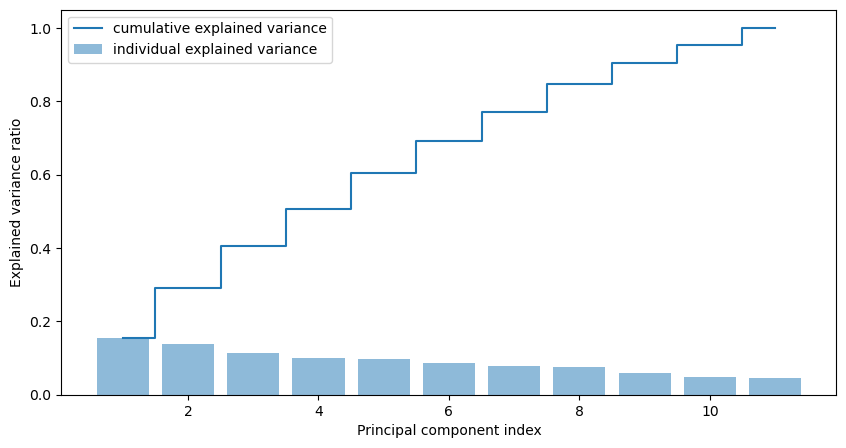

In [81]:
# Conductung Principal Component Analysis
# Defining PCA function
pca = PCA()
pca_comps = pca.fit_transform(df_pca_scaled)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# plot of explained variances
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

### **Setting to explain 80% or variance in the data..**

In [82]:
# Setting the explanation threshold
var_exp_thres = 0.80

# Finding the number of components to explain the given threshold
n_components_to_reach_thres = np.argmax(cum_var_exp >= var_exp_thres) + 1

print('Number of components to explain {:0.0f}% variance is {}'.format(var_exp_thres*100, n_components_to_reach_thres))

Number of components to explain 80% variance is 8


In [83]:
# Get the indices of the most important features based on the number of components
most_important_features_idx = [np.abs(pca.components_[i]).argmax() for i in range(n_components_to_reach_thres)]

# Get the names of the most important features
most_important_features = df_pca.columns[most_important_features_idx]

print('The most important features to explain {}% variance are:'.format(var_exp_thres*100))
print(most_important_features.values)


The most important features to explain 80.0% variance are:
['Length' 'Posted_Weekday' 'Readability_Category' 'Topic' 'Hashtags'
 'Season' 'Followers' 'Topic']


In [84]:
print('Indices of the most important features:', most_important_features_idx)


Indices of the most important features: [2, 6, 9, 10, 3, 4, 1, 10]


**Result:**<br>
'Topic' seems to be an important feature for two principal components. I.e. 'Topic' is influential in explaining different aspects or patterns of variability within the dataset. This suggests that 'Topic' has a multifaceted relationship with the other features, impacting the dataset's structure in multiple ways.

'Time_Category','Holiday' and 'Median_Income' will be dropped since they explain little to no variance in the dataset. 


## **<span style='color:#4267B2'>|</span> 6. Multilevel Analysis**

In [85]:
corr_df_cleaned.head(2)

,Type,Engagement,Followers,Length,Hashtags,Season,Gunning_Fog_Score,TimeCategory,Posted_Weekday,Holiday,Median_income,Dominant_Topic,Readability_Category,Has_Hashtag,Topic_Label
0,0,0.000222,1500412,37,0,3,8.333333,3,True,0,1,1,2,0,Renumeration post
1,0,0.000227,1500412,32,0,3,8.978049,3,True,0,1,7,2,0,Information post


In [86]:
# Creating separate df for multilevel analysis
df_multilvl = corr_df_cleaned[['Type','Engagement','Length','Posted_Weekday','Readability_Category','Hashtags',
 'Season','Followers','Topic_Label']]

In [87]:
# Convert to str
df_multilvl['Type'] = df_multilvl['Type'].astype('str')
df_multilvl['Posted_Weekday'] = df_multilvl['Posted_Weekday'].astype('str')
df_multilvl['Season'] = df_multilvl['Season'].astype('str')
df_multilvl['Readability_Category'] = df_multilvl['Readability_Category'].astype('str')
df_multilvl['Topic_Label'] = df_multilvl['Topic_Label'].astype('str')
# Convert to categorical
df_multilvl['Type'] = pd.Categorical(df_multilvl['Type'],ordered=False)
df_multilvl['Posted_Weekday'] = pd.Categorical(df_multilvl['Posted_Weekday'],ordered=False)
df_multilvl['Season'] = pd.Categorical(df_multilvl['Season'],ordered=False)
df_multilvl['Readability_Category'] = pd.Categorical(df_multilvl['Readability_Category'],ordered=False)
df_multilvl['Topic_Label'] = pd.Categorical(df_multilvl['Topic_Label'],ordered=False)

C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\2954925745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multilvl['Type'] = df_multilvl['Type'].astype('str')
C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\2954925745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multilvl['Posted_Weekday'] = df_multilvl['Posted_Weekday'].astype('str')
C:\Users\Trabala\AppData\Local\Temp\ipykernel_5064\2954925745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [88]:
model = Lmer('Engagement ~ Length + Hashtags + Readability_Category + Posted_Weekday + Season + Topic_Label + (1 + Posted_Weekday + Season | Type)', data=df_multilvl)

model.fit()

c:\Users\Trabala\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "Followers". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'int'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: Engagement~Length+Hashtags+Readability_Category+Posted_Weekday+Season+Topic_Label+(1+Posted_Weekday+Season|Type)

Family: gaussian	 Inference: parametric

Number of observations: 8998	 Groups: {'Type': 6.0}

Log-likelihood: 29740.548 	 AIC: -59427.096

Random effects:

                        Name  Var    Std
Type             (Intercept)  0.0  0.000
Type      Posted_WeekdayTrue  0.0  0.001
Type                 Season2  0.0  0.000
Type                 Season3  0.0  0.000
Type                 Season4  0.0  0.001
Residual                      0.0  0.009

                     IV1                 IV2      Corr
Type         (Intercept)  Posted_WeekdayTrue          
Type         (Intercept)             Season2          
Type         (Intercept)             Season3          
Type         (Intercept)             Season4          
Type  Posted_WeekdayTrue             Season2 -0.776936
Type  Post

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.001,0.000,0.002,0.000,8453.869,3.266,0.001,**
Length,0.000,0.000,0.000,0.000,7871.405,2.821,0.005,**
Hashtags,-0.000,-0.000,0.000,0.000,8750.027,-0.208,0.835,
Readability_Category2,-0.001,-0.001,-0.000,0.000,8922.964,-2.587,0.010,**
Readability_Category3,-0.000,-0.001,0.000,0.000,8625.581,-1.238,0.216,
Posted_WeekdayTrue,0.000,-0.001,0.001,0.000,4.599,0.566,0.598,
Season2,0.000,-0.001,0.001,0.000,9.496,0.410,0.691,
Season3,0.000,-0.000,0.001,0.000,14.563,0.599,0.558,
Season4,0.000,-0.001,0.001,0.001,4.794,0.718,0.506,
Topic_LabelInformation post,-0.000,-0.001,-0.000,0.000,8340.492,-2.012,0.044,*


In [89]:
model.fixef

,(Intercept),Length,Hashtags,Readability_Category2,Readability_Category3,Posted_WeekdayTrue,Season2,Season3,Season4,Topic_LabelInformation post,Topic_LabelRenumeration post
0,0.001115,0.000012,-0.000008,-0.000595,-0.000348,0.000048,0.000442,0.000472,0.000045,-0.000437,-0.000581
1,0.001115,0.000012,-0.000008,-0.000595,-0.000348,-0.000121,0.000234,0.000196,-0.000085,-0.000437,-0.000581
2,0.001115,0.000012,-0.000008,-0.000595,-0.000348,-0.000179,0.000196,0.000137,-0.000143,-0.000437,-0.000581
3,0.001115,0.000012,-0.000008,-0.000595,-0.000348,0.001600,-0.000450,0.000023,0.002342,-0.000437,-0.000581
4,0.001115,0.000012,-0.000008,-0.000595,-0.000348,0.000039,0.000198,0.000210,0.000129,-0.000437,-0.000581
5,0.001115,0.000012,-0.000008,-0.000595,-0.000348,-0.000126,0.000255,0.000217,-0.000099,-0.000437,-0.000581


Mapping Legend of 'Type' of park:

"Amusement park": 0<br>
"Theme City": 1<br>
"Theme park":2<br>
"Theme Amusement Park":3<br>
"Animal park":4<br>
"Water park":5

### Performing checks for model assumptions

**With the assumptions being the following:**

* **Linearity:** The relationship between the dependent variable and each of the independent variables should be linear.
* **Normality:** The residuals should be normally distributed.

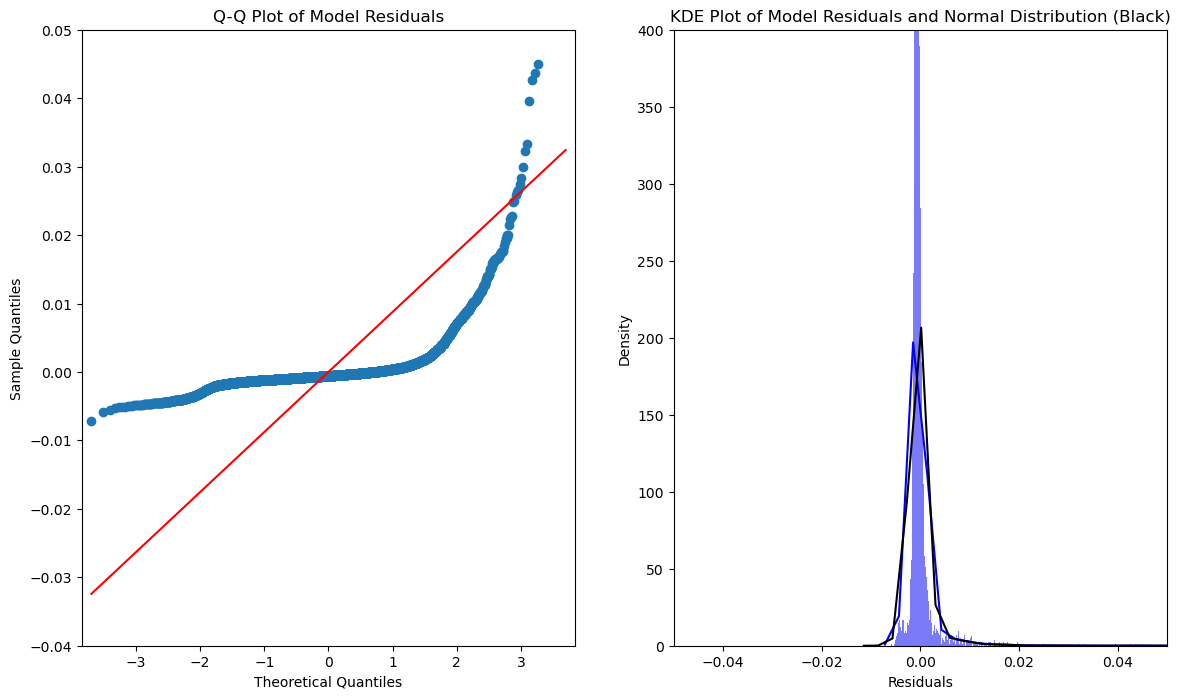

In [102]:
# Extract residuals from your model - via ChatGPT
residuals = model.residuals

# Create subplots for Q-Q plot and KDE plot
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Q-Q plot of the residuals
sm.qqplot(residuals, stats.norm, line='s', ax=axes[0])
axes[0].set_title('Q-Q Plot of Model Residuals')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')
axes[0].set_ylim(-0.04, 0.05)  # Setting y-axis limits

# KDE plot of the residuals
sns.histplot(residuals, kde=True, ax=axes[1], stat='density', color='blue')
sns.kdeplot(residuals, color='black', ax=axes[1])
axes[1].set_title('KDE Plot of Model Residuals and Normal Distribution (Black)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylim(0, 400)  # Setting y-axis limits
axes[1].set_xlim (-0.05,0.05) # Setting x-axis limits

plt.show()

In [103]:
#Shapiro test for the residuals
stats.shapiro(residuals)

c:\Users\Trabala\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.07062458992004395, pvalue=0.0)

In summary, both the Shapiro-Wilk test and the graphical examination of residuals suggest that the residuals do not adhere to a normal distribution. Consequently, the reliability of the mixed-effect multilevel model results is compromised, necessitating the consideration of an alternative modeling approach.